# Setup

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [2]:
import os
import random
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Setting seeds

In [4]:
random_state = 42
# reset session
def reset_session():
  clear_session()
  tf.compat.v1.reset_default_graph()
  gc.collect()
  # reset seeds
  random.seed(random_state)
  np.random.seed(random_state)
  tf.random.set_seed(random_state)

reset_session()

## Load data

In [6]:
DATADIR = "/content/drive/MyDrive/AquaVision/code/fishlify/boesemani_rainbow"
CATAGORIES = ["melanotaenia_boesemani_male", "melanotaenia_boesemani_female"]
IMG_SIZE = (224, 224)

In [7]:
data = []
def load_data():
  for category in CATAGORIES:
    path = os.path.join(DATADIR, category)
    class_num = category
    for img in os.listdir(path):
      image_path = os.path.join(path, img)  # Get the full image path
      image = cv2.imread(image_path)
      if image is None:
        print(f"Warning: Could not load image at {image_path}. Skipping...")
        continue
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, IMG_SIZE)
      data.append([image, class_num])

In [8]:
load_data()

In [9]:
len(data)

85

In [10]:
male = [img for img in data if img[1] == "melanotaenia_boesemani_male"]
female = [img for img in data if img[1] == "melanotaenia_boesemani_female"]
selected_male = random.sample(male, 3)
selected_female = random.sample(female, 3)

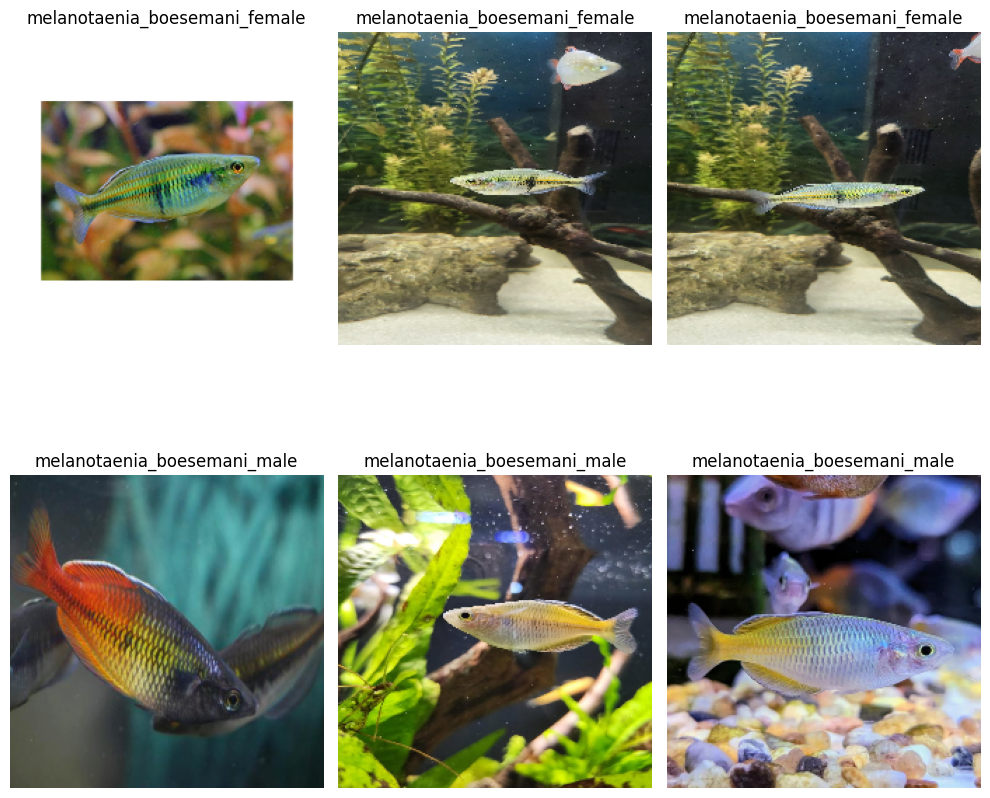

In [11]:
fig = plt.figure(figsize=(10, 10))
for i in range(6):
  ax = fig.add_subplot(2, 3, i+1)
  if i < 3:
    ax.imshow(selected_female[i][0])
    ax.set_title(selected_female[i][1])
  else:
    ax.imshow(selected_male[i-3][0])
    ax.set_title(selected_male[i-3][1])
  ax.axis("off")
plt.tight_layout()
plt.show()

## Data preprocessing

### Data split

In [12]:
X = []
y = []
for feature, label in data:  # Iterate directly through data
    X.append(np.array(feature))
    y.append(np.array(label))
X = np.array(X)
y = np.array(y)

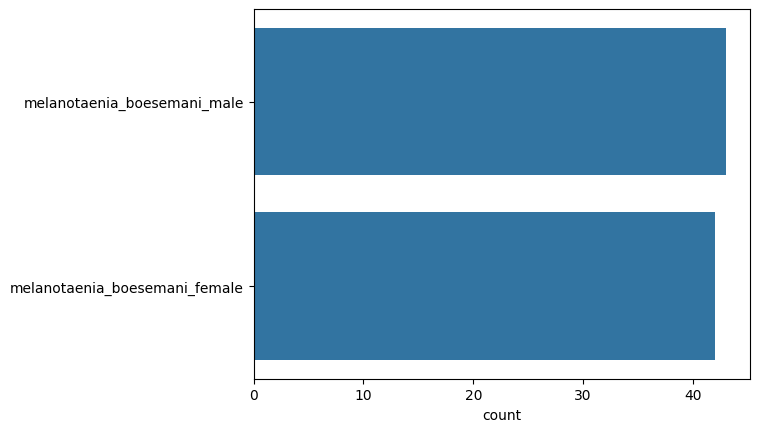

In [13]:
sns.countplot(y)
plt.show()

In [14]:
pd.Series(y).value_counts(normalize= True)

,proportion
melanotaenia_boesemani_male,0.505882
melanotaenia_boesemani_female,0.494118


In [15]:
pd.Series(y).value_counts()

,count
melanotaenia_boesemani_male,43
melanotaenia_boesemani_female,42


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [17]:
X_train.shape,X_val.shape, X_test.shape

((60, 224, 224, 3), (16, 224, 224, 3), (9, 224, 224, 3))

In [18]:
y_train.shape, y_test.shape, y_val.shape

((60,), (9,), (16,))

In [19]:
print('train - \n', pd.Series(y_train).value_counts())
print('val - \n',pd.Series(y_val).value_counts())
print('test - \n',pd.Series(y_test).value_counts())


train - 
 melanotaenia_boesemani_male      30
melanotaenia_boesemani_female    30
Name: count, dtype: int64
val - 
 melanotaenia_boesemani_male      8
melanotaenia_boesemani_female    8
Name: count, dtype: int64
test - 
 melanotaenia_boesemani_male      5
melanotaenia_boesemani_female    4
Name: count, dtype: int64


### Label encoding

In [20]:
# Convert labels manually
y_train_num = np.array([0 if label == "melanotaenia_boesemani_female" else 1 for label in y_train])
y_val_num = np.array([0 if label == "melanotaenia_boesemani_female" else 1 for label in y_val])
y_test_num = np.array([0 if label == "melanotaenia_boesemani_female" else 1 for label in y_test])

### Data augmentation

In [21]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    brightness_range=[0.9, 1.1],
    shear_range = 0.1,
    zoom_range=0.1,
    rescale=1./255,
)

train_generator = datagen.flow(X_train, y_train_num, batch_size=4, shuffle = True)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalization
# Validation generator with batch_size=1
val_generator = val_test_datagen.flow(X_val, y_val_num, batch_size=1, shuffle=False)

# Test generator with single batch
test_generator = val_test_datagen.flow(X_test, y_test_num, batch_size=len(X_test), shuffle=False)

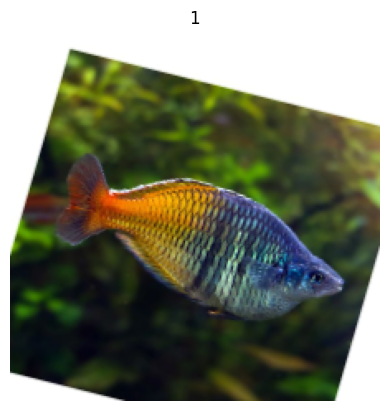

In [22]:
# Function to display image
def plot_image(image, title):
    plt.imshow(image.astype(np.uint8))  # Convert back to uint8 (0-255)
    plt.axis("off")
    plt.title(title)
    plt.show()

# Get one batch of augmented training images
aug_train_images, image_labels = next(train_generator)  # Fetch one batch
aug_train_image = (aug_train_images[0] * 255).clip(0, 255)  # Convert back to 0-255
plot_image(aug_train_image, image_labels[0])

# CNN model

### Training

In [ ]:
reset_session()

In [ ]:
cnn_model = Sequential([
    Input(shape=(224, 224, 3), name= "Input_Layer"),

    Conv2D(128, (3, 3), name = "Conv1_128"),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),

    Conv2D(64, (3, 3), name = "Conv2_64"),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),

    Conv2D(32, (3, 3), name = "Conv3_64"),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),

    Conv2D(32, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),

    # FC layer 1
    Flatten(),
    Dense(128, activation='relu', name = 'FC1_128'),
    Dropout(0.25),

    # FC layer 2
    Dense(64, activation='relu', name = 'FC2_64'),
    Dropout(0.25),

    # FC layer 3
    Dense(32, activation='relu', name = 'FC3_32'),
    Dropout(0.25),

    # Output layer
    Dense(1, activation='sigmoid', name = 'Output_12')]
)
optimizer = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/AquaVision/code/fishlify/models/basic-cnn.keras',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
history = cnn_model.fit(train_generator,
                       epochs=200,
                       validation_data=val_generator,
                       callbacks=[es, checkpoint],
                       validation_steps=len(X_val))

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5876 - loss: 0.9392
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/AquaVision/boesemani_rainbow/models/basic-cnn.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.5853 - loss: 0.9511 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5840 - loss: 0.8847
Epoch 2: val_accuracy did not improve from 0.50000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5808 - loss: 0.8903 - val_accuracy: 0.4375 - val_loss: 0.6956
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3960 - loss: 1.2512
Epoch 3: val_accuracy did not improve from 0.50000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3983 - loss: 1.2575 - val_accuracy: 0.5000 - val_loss: 0.6978
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6869 - loss: 0.8913
Epoch 4: val_accuracy did not improve from 0.50000
15/15 ━━━

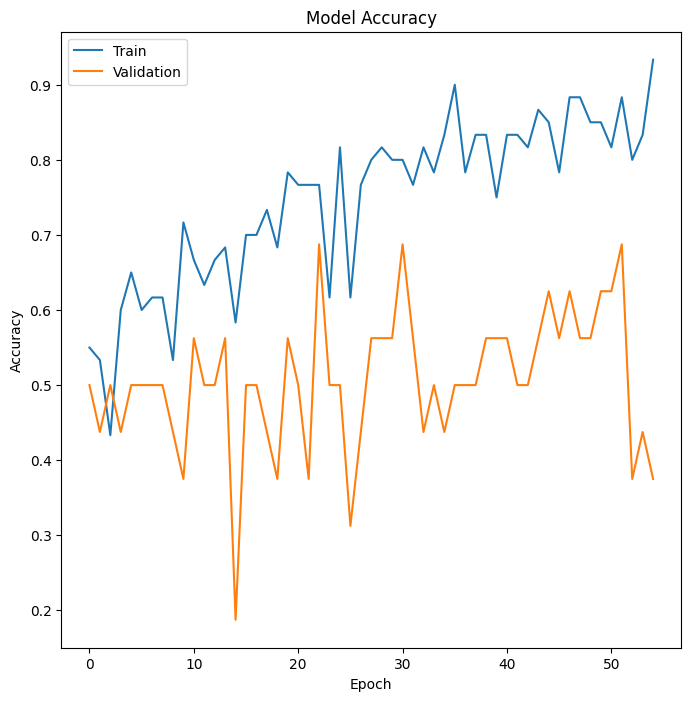

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### CNN Model Performance

In [ ]:
saved_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/AquaVision/code/fishlify/models/basic-cnn.keras')

In [ ]:
y_train_pred = saved_cnn_model.predict(train_generator)
y_val_pred = saved_cnn_model.predict(val_generator)
y_test_pred = saved_cnn_model.predict(test_generator)
y_train_pred_labels = (y_train_pred > 0.5).astype(int)
y_val_pred_labels = (y_val_pred > 0.5).astype(int)
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


In [ ]:
print('Classification report for training Set - Basic CNN Model')
print(classification_report(y_train_num, y_train_pred_labels))
print('\nClassification report for validation Set - Basic CNN Model')
print(classification_report(y_val_num, y_val_pred_labels))
print('\nClassification report for test Set - Basic CNN Model')
print(classification_report(y_test_num, y_test_pred_labels))

Classification report for training Set - Basic CNN Model
              precision    recall  f1-score   support

           0       0.58      0.37      0.45        30
           1       0.54      0.73      0.62        30

    accuracy                           0.55        60
   macro avg       0.56      0.55      0.53        60
weighted avg       0.56      0.55      0.53        60


Classification report for validation Set - Basic CNN Model
              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.71      0.62      0.67         8

    accuracy                           0.69        16
   macro avg       0.69      0.69      0.69        16
weighted avg       0.69      0.69      0.69        16


Classification report for test Set - Basic CNN Model
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.71      1.00      0.83         5

    accurac

Confusion matrix comparison - Basic CNN Model


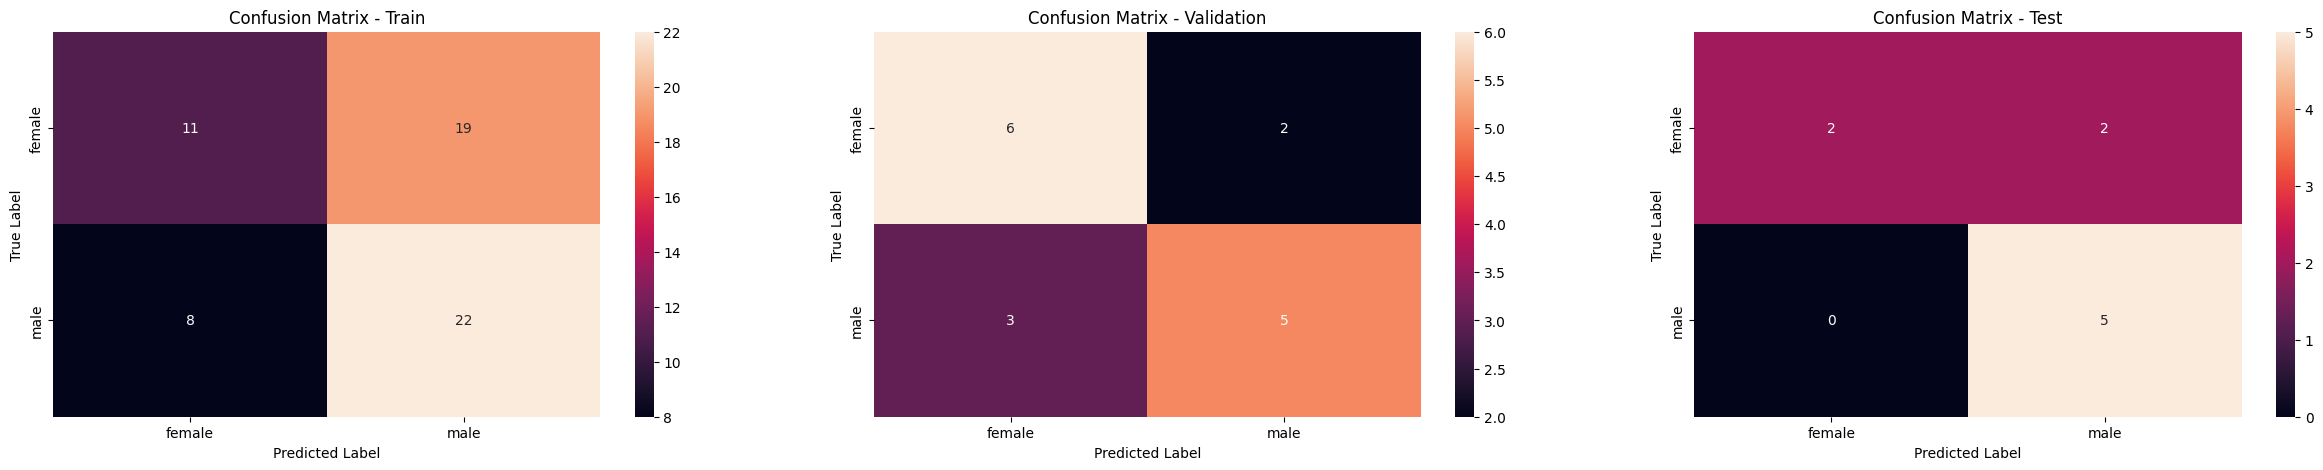

In [ ]:
cm_train_first = confusion_matrix(y_train_num, y_train_pred_labels)
cm_val_first = confusion_matrix(y_val_num, y_val_pred_labels)
cm_test_first = confusion_matrix(y_test_num, y_test_pred_labels)
print('Confusion matrix comparison - Basic CNN Model')
# Plot confusion matrix
plt.figure(figsize=(30,5))
plt.subplot(1,3,1)
sns.heatmap(cm_train_first, annot=True, fmt='d', xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Train')
plt.subplot(1,3,2)
sns.heatmap(cm_val_first, annot=True, fmt='d', xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation')
plt.subplot(1,3,3)
sns.heatmap(cm_test_first, annot=True, fmt='d', xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test')
plt.show()

# Transfer Learning - EfficientNet B0

### Training

In [ ]:
reset_session()

In [ ]:
# Load DfficientNet with pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze initial layers
base_model.trainable = False
nn_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),

    Dense(256),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),

    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.1),

    Dense(1, activation='sigmoid')
])
optimizer = Adam(learning_rate=0.001)
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/AquaVision/code/fishlify/models/effnetb0-nn.keras',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
history = nn_model.fit(train_generator,
                       epochs=200,
                       validation_data=val_generator,
                       callbacks=[es, checkpoint],
                       validation_steps=len(X_val))

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6891 - loss: 0.5708
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/AquaVision/boesemani_rainbow/models/effnetb0-nn.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 651ms/step - accuracy: 0.6835 - loss: 0.5775 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5914 - loss: 0.7375
Epoch 2: val_accuracy did not improve from 0.50000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5909 - loss: 0.7376 - val_accuracy: 0.5000 - val_loss: 0.7063
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6366 - loss: 0.7014
Epoch 3: val_accuracy did not improve from 0.50000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6343 - loss: 0.7031 - val_accuracy: 0.5000 - val_loss: 0.7128
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5243 - loss: 0.8073
Epoch 4: val_accuracy did not improve from 0.50000
15/15 ━

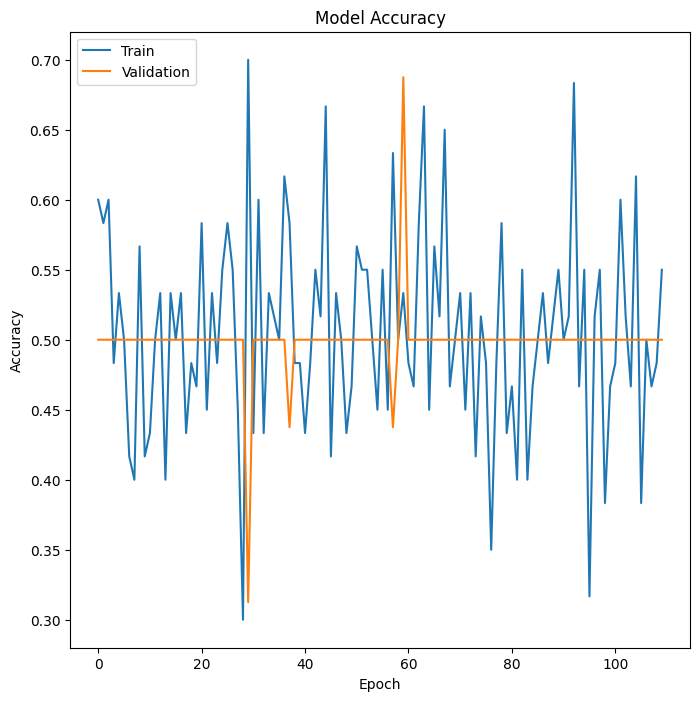

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model Performance Evaluation

In [ ]:
saved_model_effnet = tf.keras.models.load_model('/content/drive/MyDrive/AquaVision/code/fishlify/models/effnetb0-nn.keras')

In [ ]:
y_train_pred = saved_model_effnet.predict(train_generator)
y_val_pred = saved_model_effnet.predict(val_generator)
y_test_pred = saved_model_effnet.predict(test_generator)
y_train_pred_labels = (y_train_pred > 0.5).astype(int)
y_val_pred_labels = (y_val_pred > 0.5).astype(int)
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
print('Classification report for training Set - Early Saved Model')
print(classification_report(y_train_num, y_train_pred_labels))
print('\nClassification report for validation Set - Early Saved Model')
print(classification_report(y_val_num, y_val_pred_labels))
print('\nClassification report for test Set - Early Saved Model')
print(classification_report(y_test_num, y_test_pred_labels))

Classification report for training Set - Early Saved Model
              precision    recall  f1-score   support

           0       0.50      0.73      0.59        30
           1       0.50      0.27      0.35        30

    accuracy                           0.50        60
   macro avg       0.50      0.50      0.47        60
weighted avg       0.50      0.50      0.47        60


Classification report for validation Set - Early Saved Model
              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.80      0.50      0.62         8

    accuracy                           0.69        16
   macro avg       0.72      0.69      0.68        16
weighted avg       0.72      0.69      0.68        16


Classification report for test Set - Early Saved Model
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.67      0.40      0.50         5

    a

Confusion matrix comparison - EfficientNet Model


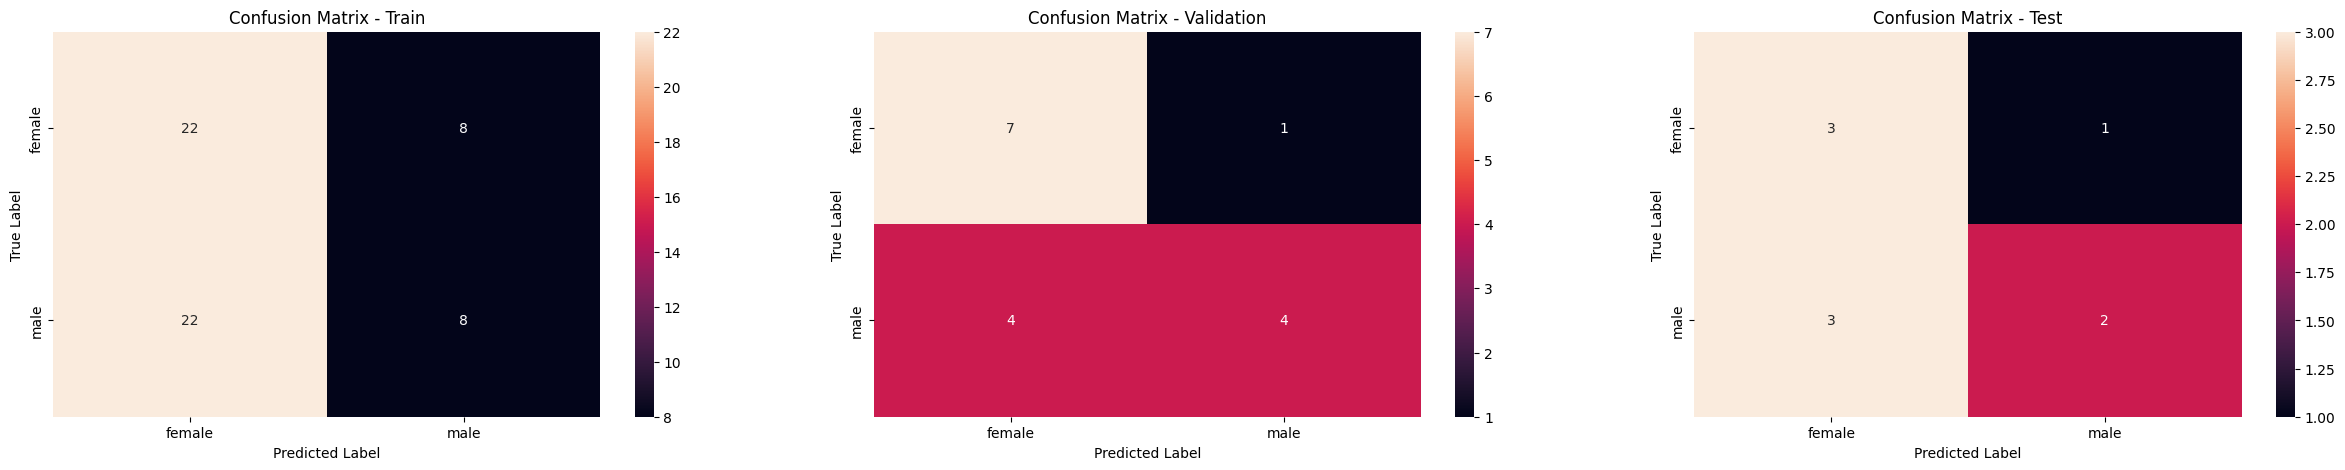

In [ ]:
cm_train = confusion_matrix(y_train_num, y_train_pred_labels)
cm_val = confusion_matrix(y_val_num, y_val_pred_labels)
cm_test = confusion_matrix(y_test_num, y_test_pred_labels)
print('Confusion matrix comparison - EfficientNet Model')
# Plot confusion matrix
plt.figure(figsize=(30,5))
plt.subplot(1,3,1)
sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Train')
plt.subplot(1,3,2)
sns.heatmap(cm_val, annot=True, fmt='d', xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation')
plt.subplot(1,3,3)
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test')
plt.show()

# Transfer Learning - RestNet50V2

### Training

In [ ]:
reset_session()

In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3)
)
base_model.trainable = False
nn_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),

    Dense(256),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),

    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.1),

    Dense(1, activation='sigmoid')
])
optimizer = Adam(learning_rate=0.001)
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/AquaVision/code/fishlify/models/restnet50v2-nn.keras',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
history = nn_model.fit(train_generator,
                       epochs=200,
                       validation_data=val_generator,
                       callbacks=[es, checkpoint],
                       validation_steps=len(X_val))

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5669 - loss: 0.7666
Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to /content/drive/MyDrive/AquaVision/boesemani_rainbow/models/restnet50v2-nn.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 582ms/step - accuracy: 0.5648 - loss: 0.7678 - val_accuracy: 0.4375 - val_loss: 0.7481
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5596 - loss: 0.7760
Epoch 2: val_accuracy improved from 0.43750 to 0.50000, saving model to /content/drive/MyDrive/AquaVision/boesemani_rainbow/models/restnet50v2-nn.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.5601 - loss: 0.7740 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6459 - loss: 0.6541
Epoch 3: val_accuracy did not improve from 0.50000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.6431 - loss: 0.6553 - val_accuracy: 0.5000 - val_loss: 0.7073
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━

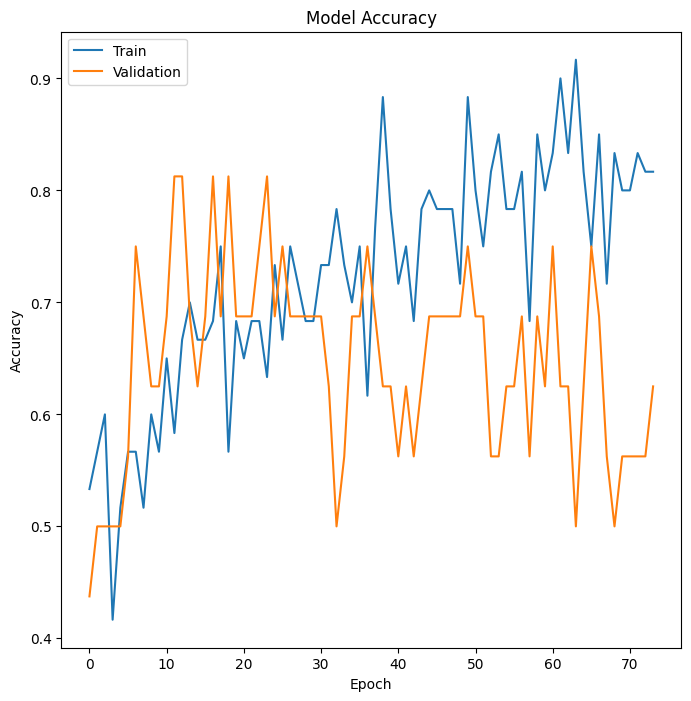

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model performance evaluation

In [ ]:
saved_model_restnet = tf.keras.models.load_model('/content/drive/MyDrive/AquaVision/code/fishlify/models/restnet50v2-nn.keras')

In [ ]:
y_train_pred = saved_model_restnet.predict(train_generator)
y_val_pred = saved_model_restnet.predict(val_generator)
y_test_pred = saved_model_restnet.predict(test_generator)
y_train_pred_labels = (y_train_pred > 0.5).astype(int)
y_val_pred_labels = (y_val_pred > 0.5).astype(int)
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
print('Classification report for training Set - restnet50v2 Model')
print(classification_report(y_train_num, y_train_pred_labels))
print('\nClassification report for validation Set - restnet50v2 Model')
print(classification_report(y_val_num, y_val_pred_labels))
print('\nClassification report for test Set - restnet50v2 Model')
print(classification_report(y_test_num, y_test_pred_labels))

Classification report for training Set - restnet50v2 Model
              precision    recall  f1-score   support

           0       0.41      0.37      0.39        30
           1       0.42      0.47      0.44        30

    accuracy                           0.42        60
   macro avg       0.42      0.42      0.42        60
weighted avg       0.42      0.42      0.42        60


Classification report for validation Set - restnet50v2 Model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16


Classification report for test Set - restnet50v2 Model
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.80      0.89         5

    a

Confusion matrix comparison - EfficientNet Model


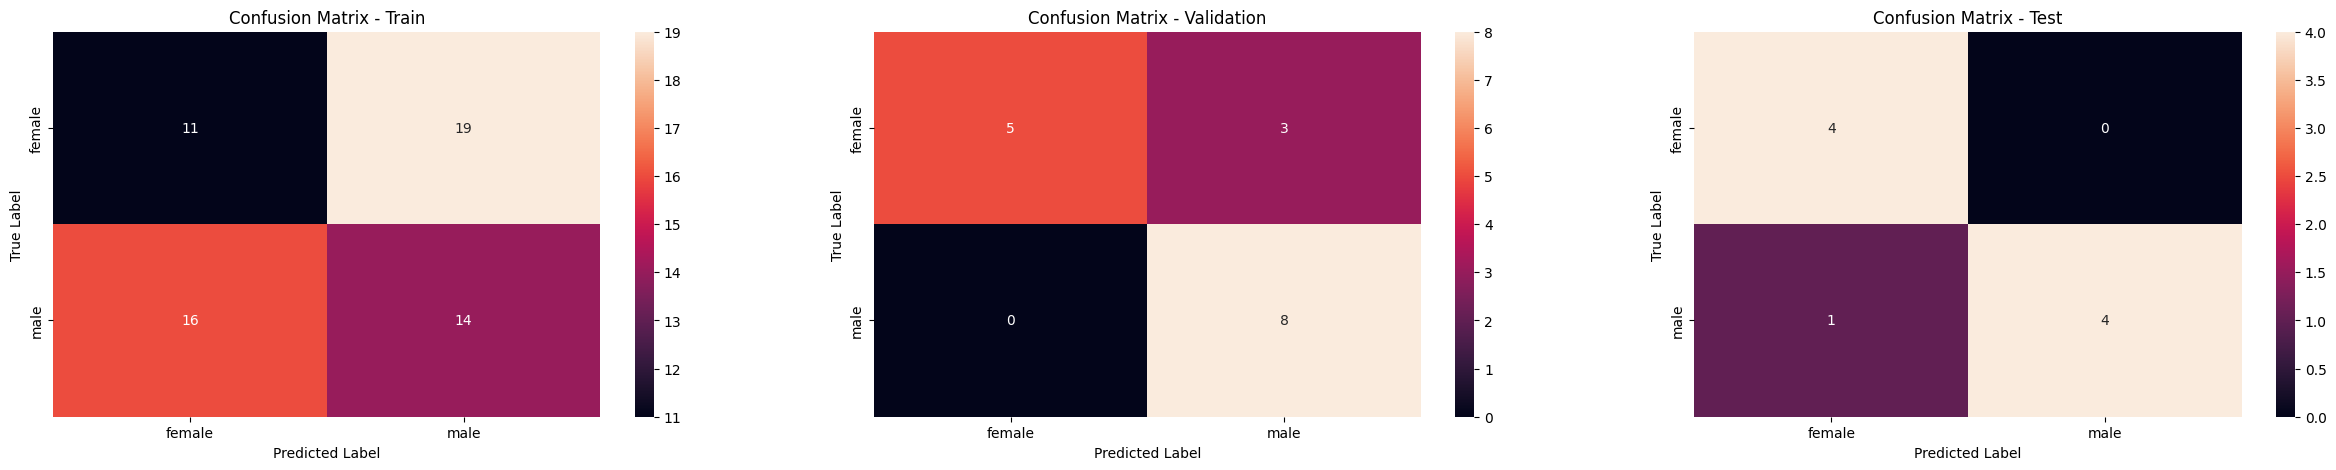

In [ ]:
cm_train = confusion_matrix(y_train_num, y_train_pred_labels)
cm_val = confusion_matrix(y_val_num, y_val_pred_labels)
cm_test = confusion_matrix(y_test_num, y_test_pred_labels)
print('Confusion matrix comparison - EfficientNet Model')
# Plot confusion matrix
plt.figure(figsize=(30,5))
plt.subplot(1,3,1)
sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Train')
plt.subplot(1,3,2)
sns.heatmap(cm_val, annot=True, fmt='d', xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation')
plt.subplot(1,3,3)
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test')
plt.show()